In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
def sensor_model(x_true):
    noise = np.random.normal(0, 0.05, size=2)
    return x_true + noise  # noisy measurement of [theta, omega]

In [3]:
def pendulum_dynamics(t, x, u, disturbance_func_on=False, feedback=None, return_disturbance=False):
    theta, omega = x
    m = 1.0     # mass (kg)
    l = 1.0     # length (m)
    g = 9.81    # gravity (m/s^2)
    b = 0.115   # damping coefficient
    I = m * l**2  # moment of inertia
    
    d = forcing_disturbance(t, feedback) if disturbance_func_on else 0.0

    torque = u + d  # total torque input, d(t)

    dtheta_dt = omega
    domega_dt = (torque - b * omega - m * g * l * np.sin(theta)) / I

    if return_disturbance:
        return [dtheta_dt, domega_dt], d
    return [dtheta_dt, domega_dt]

In [ ]:

params = {
    'm': 1.0,     # pendulum mass
    'l': 1.0,     # pendulum length
    'g': 9.81,    # gravity
    'M': 5.0,     # beam mass
    'J': 0.1,     # pendulum rotational inertia
    'b': 0.05     # damping coefficient
}


In [4]:
class EKFObserver:
    def __init__(self, Q, R):
        # Ensure float dtype so in-place additions with float deltas don't raise a UFuncTypeError
        self.x_hat = np.array([0.0, 1.0], dtype=float)  # initial state estimate (float)
        self.P = np.eye(2, dtype=float)        # initial covariance
        self.Q = Q.astype(float)               # process noise covariance
        self.R = R.astype(float)               # measurement noise covariance
        self.last_K = np.zeros((2,2), dtype=float)  # will hold most recent Kalman gain

    def predict(self, u, dt):
        f = pendulum_dynamics(0, self.x_hat, u)  # no disturbance in prediction
        # f returns a list of floats; in-place add is now safe because x_hat is float
        self.x_hat += np.array(f, dtype=float) * dt
        self.P += self.Q * dt

    def update(self, y):
        H = np.eye(2)  # measurement matrix
        y_hat = self.x_hat
        S = H @ self.P @ H.T + self.R
        K = self.P @ H.T @ np.linalg.inv(S)
        self.x_hat += K @ (y - y_hat)
        self.P = (np.eye(2) - K @ H) @ self.P
        self.last_K = K  # store Kalman gain

    def step(self, u, y, dt):
        self.predict(u, dt)
        self.update(y)
        return self.x_hat

In [5]:
def forcing_disturbance(t,feedback=None):
    if feedback == None:
        feedback=1
    return 0.5 * np.sin(0.1 * t+np.deg2rad(20))/np.abs((feedback*np.random.normal(10, 0.05)))

In [6]:
class PIDController:
    def __init__(self, Kp, Ki, Kd):
        self.Kp, self.Ki, self.Kd = Kp, Ki, Kd
        self.integral = 0.0
        self.prev_error = 0.0
        self.integral_history=[]
        self.error_history=[]
        self.derivative_history=[]

    def compute(self, error, dt):
        self.integral += error * dt
        derivative = (error - self.prev_error) / dt
        self.prev_error = error
        # record histories
        self.error_history.append(error)
        self.integral_history.append(self.integral)
        self.derivative_history.append(derivative)
        return self.Kp * error + self.Ki * self.integral + self.Kd * derivative

In [7]:
dt = 0.02
T = 100
times = np.arange(0, T, dt)

x = np.array([0.1, 0.0], dtype=float)  # true initial state

# Histories
x_history = [x.copy()]        # true state trajectory
x_hat_history = []             # observer estimates
u_history = []                 # control inputs
error_history = []             # tracking errors
sensor_history = []            # noisy measurements
dx_history = []                # state derivatives
K_history = []                 # Kalman gains
P_history = []                 # Covariance matrices
Q_history = []                 # Process noise matrices
R_history = []                 # Measurement noise matrices
pid_integral_history = []      # integral term
pid_derivative_history = []    # derivative term (mirrors controller history)
forcing_history = []           # disturbance values d(t)

# Components
ekf = EKFObserver(Q=np.eye(2)*0.01, R=np.eye(2)*0.05)
pid = PIDController(Kp=10, Ki=1, Kd=2)

# Reference / initial control
desired_theta = 10.0
u = 0.0  # control applied over first interval

In [ ]:
# For simple pendulum
for k, t in enumerate(times):
    # 1. Propagate true system with control u applied over this interval
    if t>4:
        dx, d_val = pendulum_dynamics(t, x, u, disturbance_func_on=True, feedback=dx_history[-2][0], return_disturbance=True)
    else: 
        dx, d_val = pendulum_dynamics(t, x, u, disturbance_func_on=True, return_disturbance=True)
    x += np.array(dx) * dt

    # 2. Take noisy measurement
    y = sensor_model(x)

    # 3. EKF step using SAME control that was just applied
    x_hat = ekf.step(u=u, y=y, dt=dt)

    # 4. Compute control for NEXT interval from updated estimate
    error = desired_theta - x_hat[0]
    u_next = pid.compute(error, dt)

    # 5. Log histories
    dx_history.append(dx)
    x_history.append(x.copy())
    x_hat_history.append(x_hat.copy())
    u_history.append(u)
    error_history.append(error)
    sensor_history.append(y.copy())
    forcing_history.append(d_val)

    # EKF internals
    K_history.append(ekf.last_K.copy())
    P_history.append(ekf.P.copy())
    Q_history.append(ekf.Q.copy())
    R_history.append(ekf.R.copy())

    # PID internals (redundant but separate convenient copies)
    pid_integral_history.append(pid.integral)
    pid_derivative_history.append(pid.derivative_history[-1])

    # 6. Advance control
    u = u_next

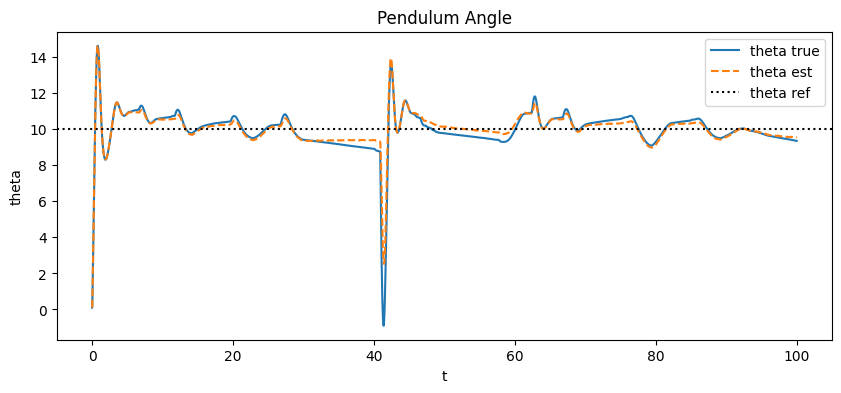

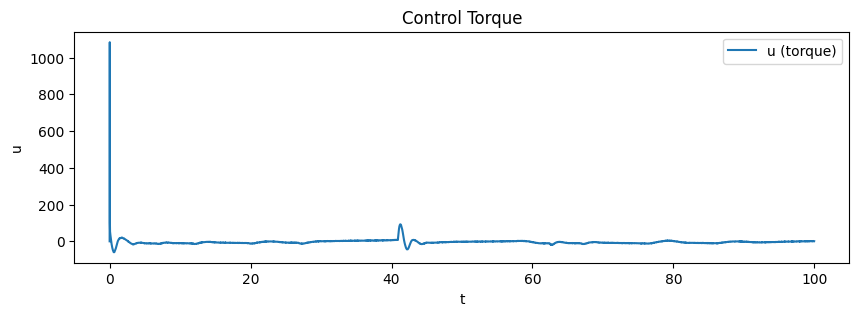

In [9]:
# Plot theta (true vs estimate)
plt.figure(figsize=(10,4))
plt.plot(times, [x[0] for x in x_history[1:]], label='theta true')
plt.plot(times, [xh[0] for xh in x_hat_history], '--', label='theta est')
plt.axhline(desired_theta, color='k', linestyle=':', label='theta ref')
#plt.xlim(20,100)
#plt.ylim(9.5,10.5)
plt.legend(); plt.title('Pendulum Angle')
plt.xlabel('t'); plt.ylabel('theta')

# Control input
plt.figure(figsize=(10,3))
plt.plot(times, u_history, label='u (torque)')
#plt.xlim(20,100)
#plt.ylim(-20,20)
plt.xlabel('t'); plt.ylabel('u'); plt.title('Control Torque'); plt.legend()

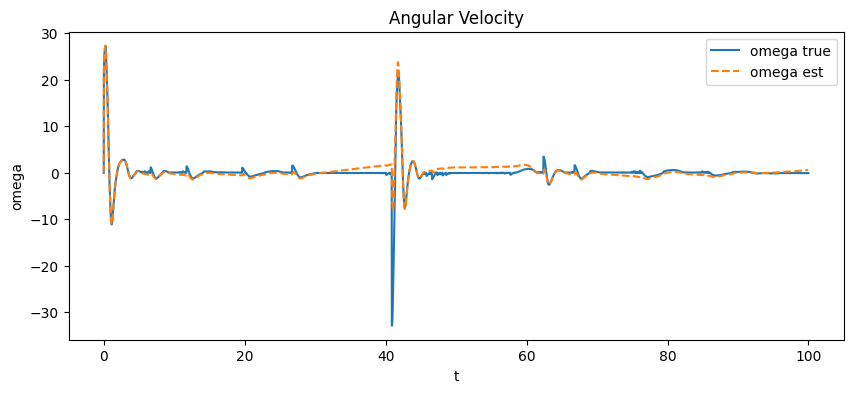

In [10]:
plt.figure(figsize=(10,4))
plt.plot(times, [x[1] for x in x_history[1:]], label='omega true')
plt.plot(times, [xh[1] for xh in x_hat_history], '--', label='omega est')
#plt.xlim(15,500)
#plt.ylim(-1,1)
plt.xlabel('t'); plt.ylabel('omega'); plt.title('Angular Velocity'); plt.legend()

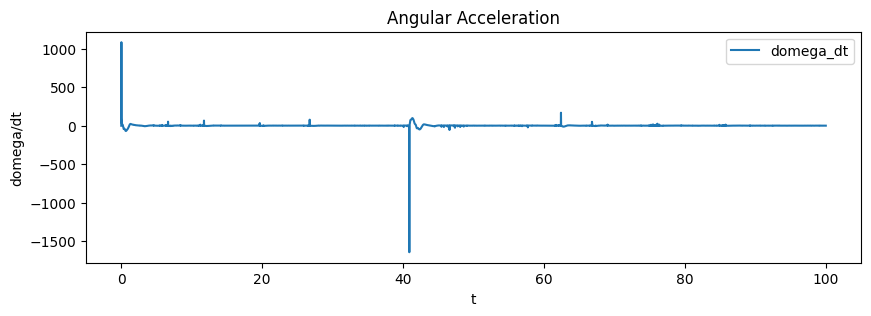

In [11]:
plt.figure(figsize=(10,3))
plt.plot(times, [dx[1] for dx in dx_history], label='domega_dt')
#plt.xlim(20,100)
#plt.ylim(-3,3)
plt.xlabel('t'); plt.ylabel('domega/dt'); plt.title('Angular Acceleration'); plt.legend()

In [12]:
# Assemble histories into a flat DataFrame and save to CSV
# Convert list-of-matrices histories (K, P, Q, R) by flattening per step

n_steps = len(x_hat_history)

def pad(arr, target):
    # helper if lengths differ (should not); pads with NaN
    if len(arr) == target:
        return arr
    return arr + [np.nan]*(target-len(arr))

sensor_theta = [m[0] for m in sensor_history]
sensor_omega = [m[1] for m in sensor_history]

cols = {
    't': times[:n_steps],
    'theta_true': [s[0] for s in x_history[1:1+n_steps]],
    'omega_true': [s[1] for s in x_history[1:1+n_steps]],
    'theta_hat': [s[0] for s in x_hat_history],
    'omega_hat': [s[1] for s in x_hat_history],
    'theta_meas': sensor_theta,
    'omega_meas': sensor_omega,
    'forcing_d': forcing_history,
    'u': u_history,
    'error': error_history,
    'pid_integral': pid_integral_history,
    'pid_derivative': pid_derivative_history,
}

# Flatten 2x2 matrices
for name, hist in [('K', K_history), ('P', P_history), ('Q', Q_history), ('R', R_history)]:
    if hist:
        mats = np.array(hist)  # shape (N,2,2)
        cols[f'{name}00'] = mats[:,0,0]
        cols[f'{name}01'] = mats[:,0,1]
        cols[f'{name}10'] = mats[:,1,0]
        cols[f'{name}11'] = mats[:,1,1]

# Build DataFrame
max_len = max(len(v) for v in cols.values())
for k,v in list(cols.items()):
    if len(v) < max_len:
        cols[k] = pad(list(v), max_len)

df = pd.DataFrame(cols)

csv_path = 'data/data_pendulum/simulation_histories.csv'
df.to_csv(csv_path, index=False)
print(f'Saved histories to {csv_path} with shape {df.shape} and columns: {list(df.columns)}')

Saved histories to data/data_pendulum/simulation_histories.csv with shape (5000, 28) and columns: ['t', 'theta_true', 'omega_true', 'theta_hat', 'omega_hat', 'theta_meas', 'omega_meas', 'forcing_d', 'u', 'error', 'pid_integral', 'pid_derivative', 'K00', 'K01', 'K10', 'K11', 'P00', 'P01', 'P10', 'P11', 'Q00', 'Q01', 'Q10', 'Q11', 'R00', 'R01', 'R10', 'R11']
